* 트리 시각화
* Accuracy 계산 : metrics.accuracy_score() 함수 사용
* Pruning the Tree 를 통해 모델 성능 높이기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [3]:
data = pd.read_csv('diabetes.csv')

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [6]:
list(y.unique())

[1, 0]

In [7]:
feature_names = X.columns.tolist()
class_names = ['No', 'Yes']    ## 일단 [0,1] 순서대로

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
# 트리 시각화를 위한 모듈 import
!pip install pydot

In [12]:
import pydot
from sklearn.tree import export_graphviz 
from IPython.core.display import Image 

In [14]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [15]:
dot_data = export_graphviz(clf, out_file = None, # out_file: 파일로 내보내고자 하는 것이 아니라 직접 그리기 때문에 None
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, # 색 넣어줌
                                rounded = True, # 반올림
                                special_characters = True) # 특수문자를 대비해서 넣어주는 옵션

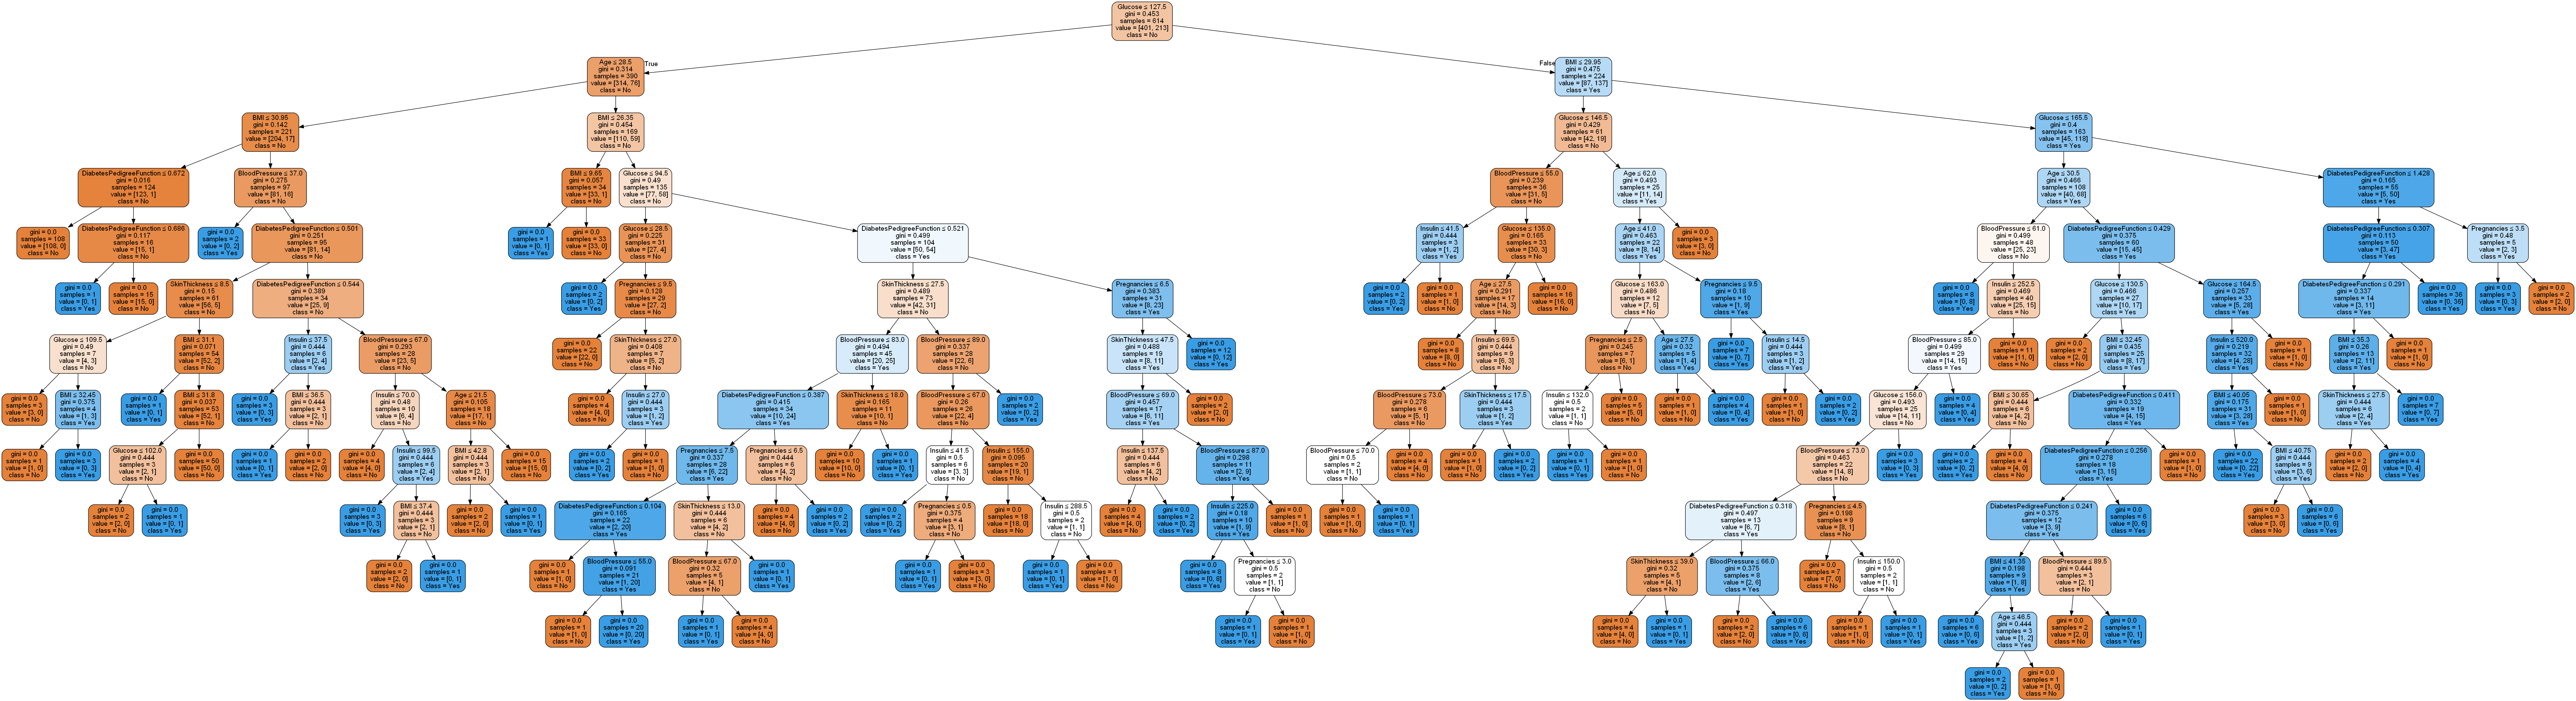

In [16]:
graph = pydot.graph_from_dot_data(dot_data)[0]
image = graph.create_png()
Image(image)

In [17]:
# 함수로 만듦
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

## Pruning

#### 1) Hyperparameter tuning (사전 가지치기)

In [42]:
from sklearn.model_selection import cross_validate
import numpy as np
scoring = ['accuracy']
tree_scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter tuning 전 Accuracy : {:.3f}".format(np.mean(tree_scores['test_accuracy'])))

parameter tuning 전 Accuracy : 0.723


In [43]:
from sklearn.model_selection import GridSearchCV

hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=clf, param_grid=hyperparamters, cv=5, verbose=1)

GridCV.fit(X_train, y_train)
GridCV.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 3, 'min_samples_split': 2}

In [44]:
tree_tuned = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=42)
tree_tuned_scores = cross_validate(tree_tuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter tuning 후 Accuracy : {:.3f}".format(np.mean(tree_tuned_scores['test_accuracy'])))

parameter tuning 후 Accuracy : 0.757


#### 2. 사후 가지치기

In [27]:
import matplotlib.pyplot as plt

In [28]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

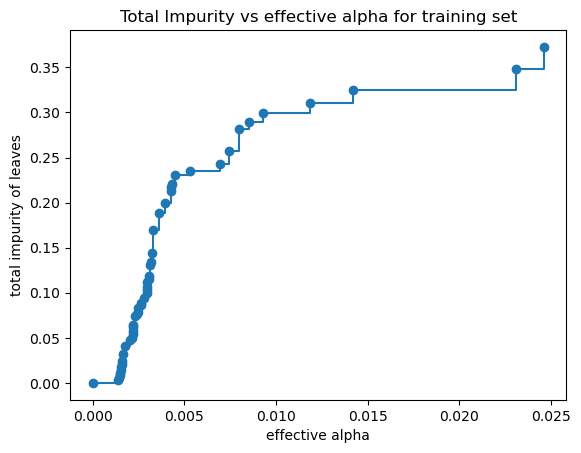

In [31]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
# clfs = []
# count = 0
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
#     clf = clf.fit(X_train, y_train)
#     count += 1
#     print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
#       count, clf.tree_.node_count, ccp_alpha))
#     display(draw_decision_tree(clf, feature_names, class_names))
#     clfs.append(clf)
#     print("====================================================================================")

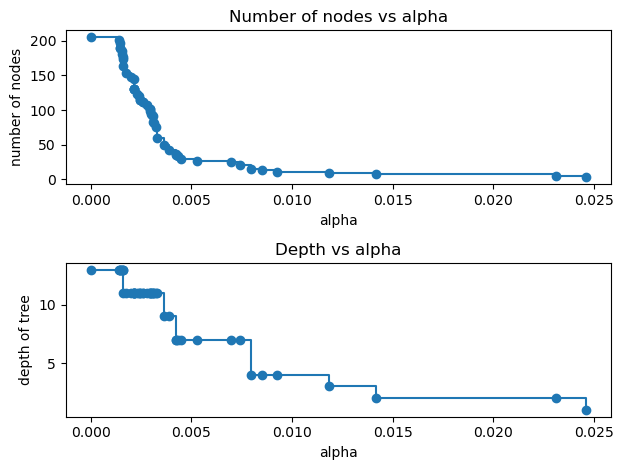

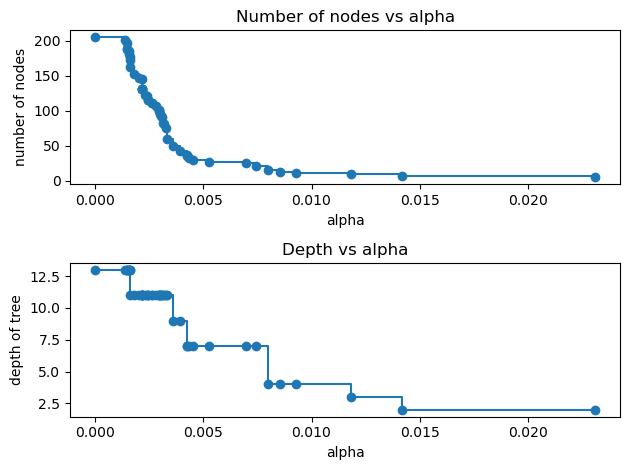

In [34]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

plt.show()

#### Accuracy 가장 높이기 ?

In [35]:
tree_nottuned = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

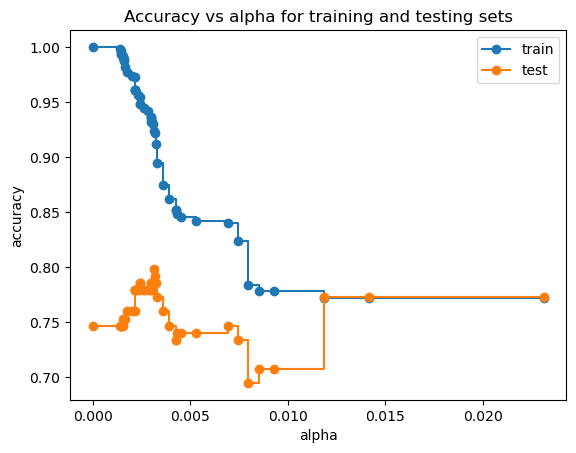

Decision tree without pruning : 205 nodes, 0.747 accuracy
Decision tree with the best pruning : 83 nodes, 0.799 accuracy


In [36]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_nottuned.tree_.node_count, tree_nottuned.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

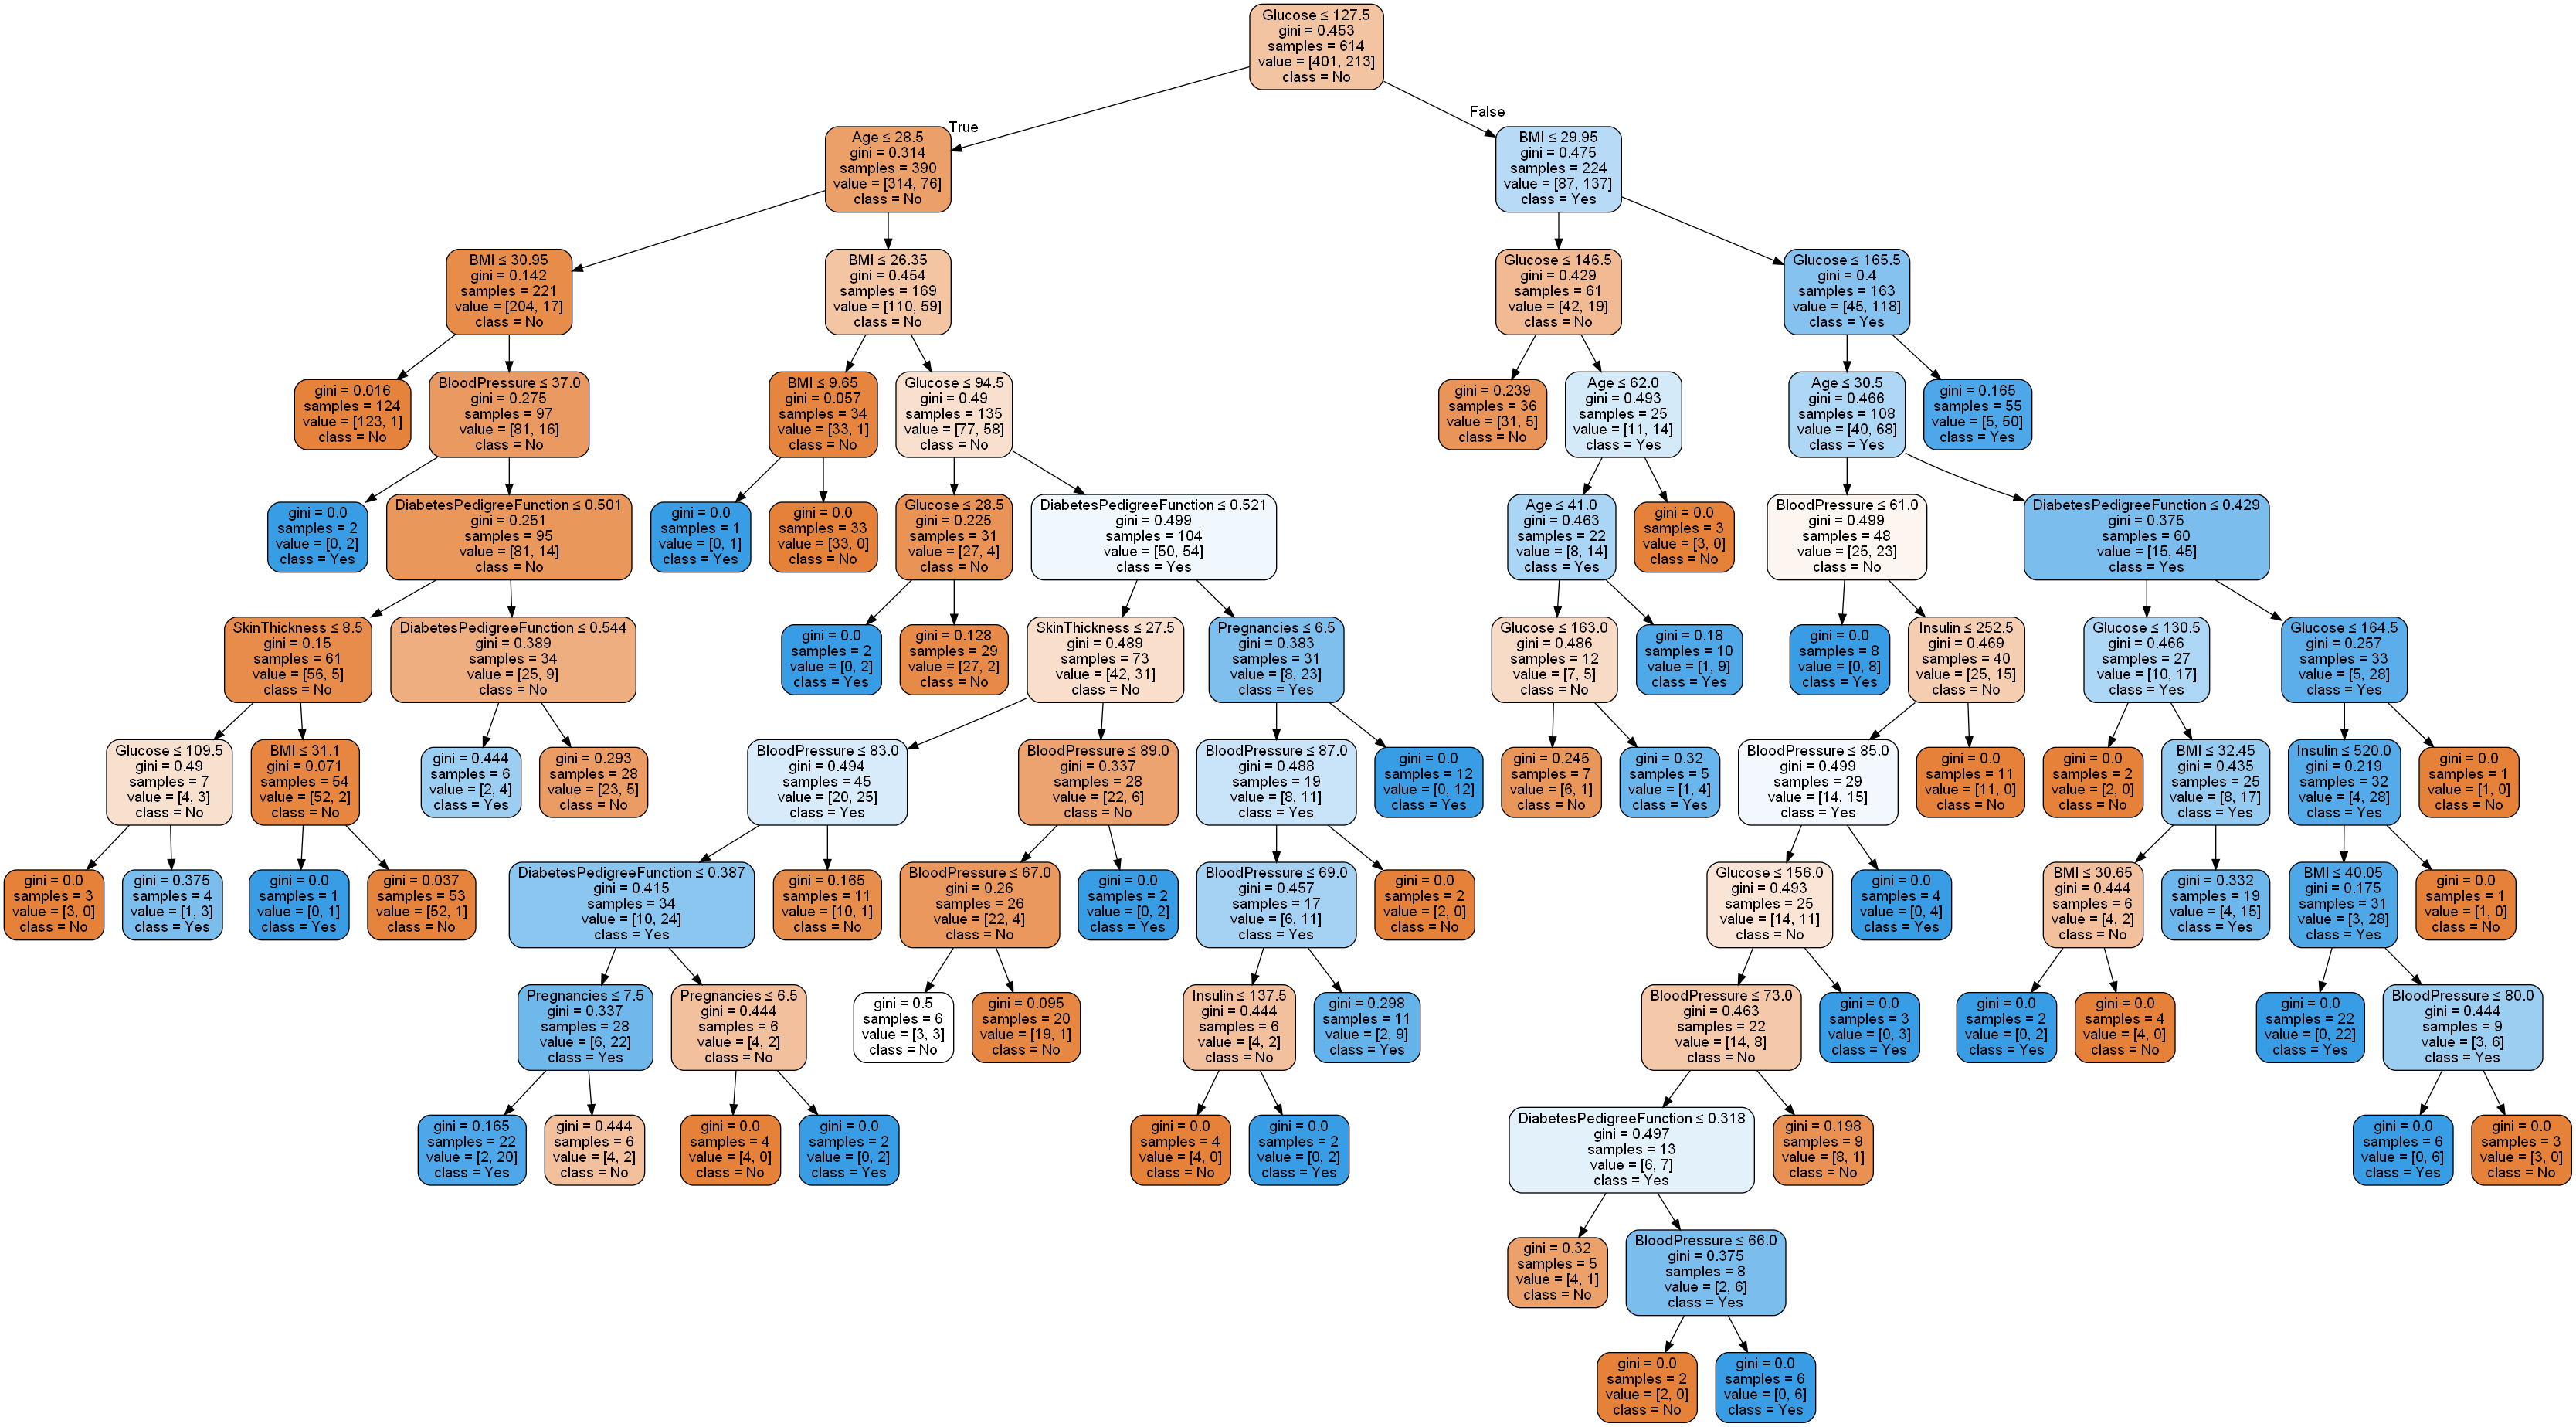

In [37]:
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.003)
clf = clf.fit(X_train, y_train)
draw_decision_tree(clf, feature_names, class_names)